## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
!nvidia-smi

Wed Mar  9 07:35:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from tensorflow import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
train, test = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [4]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu")(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu")(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               32896 

In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.9
MONITOR = ["val_loss", "val_accuracy"]
PATIENCE = [5, 10, 25]

In [8]:
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    verbose=2)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Epoch 1/50
196/196 - 5s - loss: 1.9236 - accuracy: 0.3396 - val_loss: 1.8156 - val_accuracy: 0.3629 - 5s/epoch - 27ms/step
Epoch 2/50
196/196 - 2s - loss: 1.6124 - accuracy: 0.4355 - val_loss: 1.6502 - val_accuracy: 0.4206 - 2s/epoch - 9ms/step
Epoch 3/50
196/196 - 2s - loss: 1.5114 - accuracy: 0.4740 - val_loss: 1.6086 - val_accuracy: 0.4304 - 2s/epoch - 8ms/step
Epoch 4/50
196/196 - 2s - loss: 1.4452 - accuracy: 0.4931 - val_loss: 1.5598 - val_accuracy: 0.4494 - 2s/epoch - 9ms/step
Epoch 5/50
196/196 - 2s - loss: 1.3898 - accuracy: 0.5118 - val_loss: 1.5412 - val_accuracy: 0.4625 - 2s/epoch - 9ms/step
Epoch 6/50
196/196 - 2s - loss: 1.3444 - accuracy: 0.5305 - val_loss: 1.5110 - val_accuracy: 0.4651 - 2s/epoch - 9ms/step
Epoch 7/50
196/196 - 2s - loss: 1.3021 - accuracy: 0.5452 - val_loss: 1.5036 - val_accuracy: 0.4696 - 2s/epoch - 9ms/step
Epoch 8/50
196/196 - 2s - loss: 1.2643 - accuracy: 0.5584 - val_loss: 1.5044 - val_accuracy: 0.4712 - 2s/epoch - 8ms/step
Epoch 9/50
196/196 - 2s

In [9]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping

results = {}

for mon in MONITOR:
    for pat in PATIENCE:
        keras.backend.clear_session()
        
        print(f"Experiment: Monitor-{mon}, Patience-{pat}")
        
        model = build_mlp(input_shape=x_train.shape[1:])
        
        earlystop = EarlyStopping(monitor=mon, 
                                  patience=pat, 
                                  verbose=2)

        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        history = model.fit(x_train, y_train, 
                            epochs=EPOCHS, 
                            batch_size=BATCH_SIZE, 
                            validation_data=(x_test, y_test), 
                            shuffle=True,
                            verbose=0, 
                            callbacks=[earlystop])
        
        earlystop = len(history.history["loss"])
        exp_name_tag = f"Monitor-{mon}, Patience-{pat}, Earlystop-{earlystop}"
        
        results[exp_name_tag] = earlystop

Experiment: Monitor-val_loss, Patience-5
Epoch 18: early stopping
Experiment: Monitor-val_loss, Patience-10
Epoch 25: early stopping
Experiment: Monitor-val_loss, Patience-25
Epoch 35: early stopping
Experiment: Monitor-val_accuracy, Patience-5
Epoch 25: early stopping
Experiment: Monitor-val_accuracy, Patience-10
Epoch 29: early stopping
Experiment: Monitor-val_accuracy, Patience-25
Epoch 41: early stopping


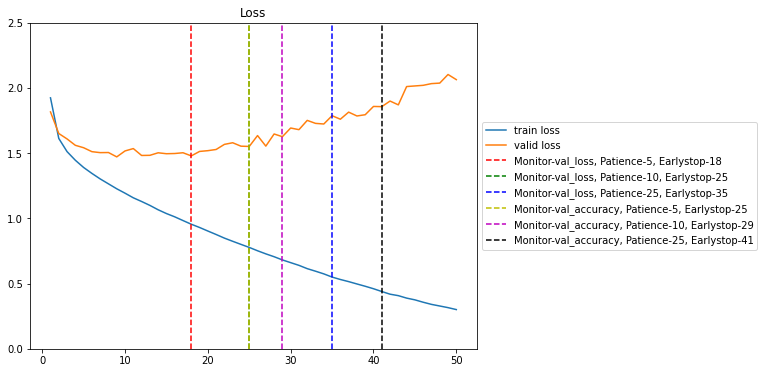

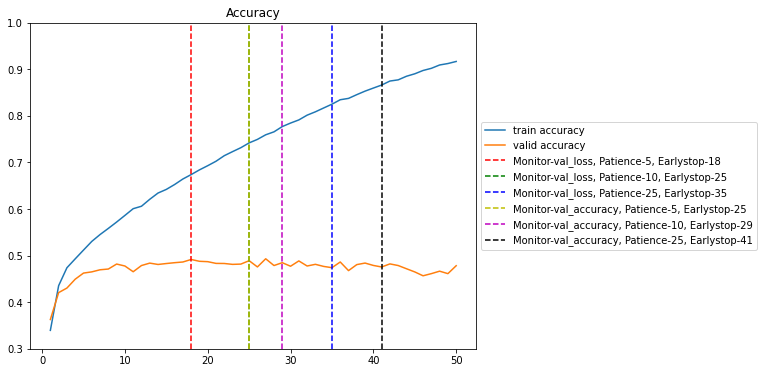

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline


color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss)+1), train_loss, label="train loss")
plt.plot(range(1, len(valid_loss)+1), valid_loss, label="valid loss")

for i, cond in enumerate(results.keys()):
    plt.axvline(x=results[cond], ymin=0, ymax=2.5, ls='--', label=cond, color=color_bar[i])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Loss")
plt.ylim((0, 2.5))
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_acc)+1), train_acc, label="train accuracy")
plt.plot(range(1, len(valid_acc)+1), valid_acc, label="valid accuracy")

for i, cond in enumerate(results.keys()):
    plt.axvline(x=results[cond], ymin=0, ymax=1, ls='--', label=cond, color=color_bar[i])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy")
plt.ylim((0.3, 1))
plt.show()